# Tarea 3: Procesamiento de Datos
- Fernando Barajas Ramírez
- Matrícula: 2085375
- Github: https://github.com/ferbarajas/ProcesamientoFCFM

In [64]:
import pandas as pd
import numpy as np

# Cargar semilla para poder dar reproducibilidad (1)
np.random.seed(1234)

# Cargar base de datos
df = pd.read_csv("G:\My Drive\MCD\TRABAJO DE CLASE\(T4) Procesamiento de Datos\Tarea 3\phones.csv")
df.head()

,title,body,brand
0,Stupid phone,DON'T BUY OUT OF SERVICE,Motorola
1,Phones locked,1 star because the phones locked so I have to ...,Motorola
2,Excellent product,The product has been very good. I had used thi...,Motorola
3,"Nice, but",I bought this phone to replace an LG phone tha...,Motorola
4,It seems it doesn't work with the existing AT&...,I purchased this phone for my AT&T phone repla...,Motorola


Visualización de reseñas por marca:

array([<AxesSubplot:ylabel='ones'>], dtype=object)

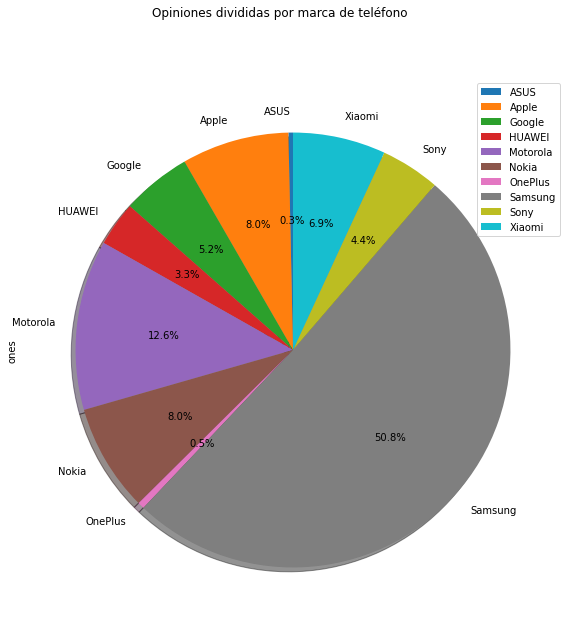

In [65]:
# Se agrega una columna de 1s para lograr la suma de la cantidad de reseñas por marca
df['ones'] = np.ones((df['brand'].shape[0], 1))

# Gráfico por marca
df.groupby(['brand']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=90,figsize=(15,10), autopct='%1.1f%%',title='Opiniones divididas por marca de teléfono')

Para esta tarea se realiza una comparativa entre las marcas Samsung y Apple. Para esto se extraen subconjuntos de cada marca, donde se observa que Samsung tiene una cantidad mucho mayor de datos:

Samsung:  (30997, 4) 

Apple:  (4875, 4) 



array([<AxesSubplot:ylabel='ones'>], dtype=object)

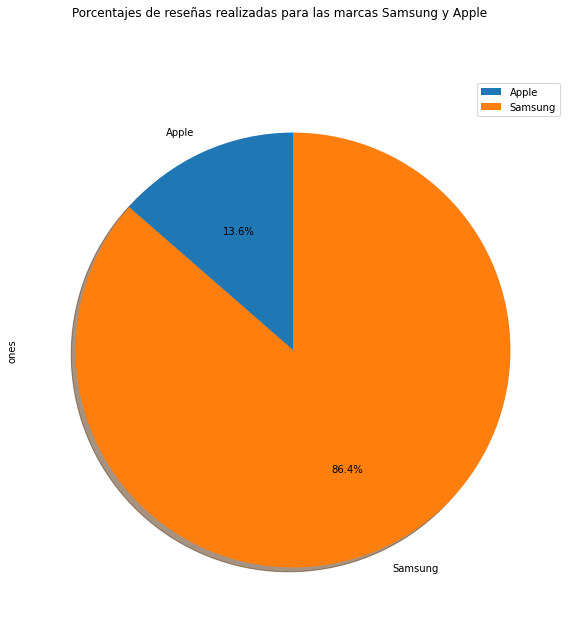

In [66]:
brand1 = df[(df.brand == "Samsung")]
brand2 = df[(df.brand == "Apple")]
print("Samsung: ", brand1.shape,"\n")
print("Apple: ", brand2.shape,"\n")

df_temp = pd.concat([brand1, brand2])

# Porcentaje por marcas de intéres
df_temp.groupby(['brand']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=90,figsize=(15,10), autopct='%1.1f%%',title='Porcentajes de reseñas realizadas para las marcas Samsung y Apple')

Se realiza un muestreo de las reseñas de Samsung, para disminuir la cantidad de datos a analizar:

Samsung subset:  (4875, 4) 

Datos:  (9750, 4) 



array([<AxesSubplot:ylabel='ones'>], dtype=object)

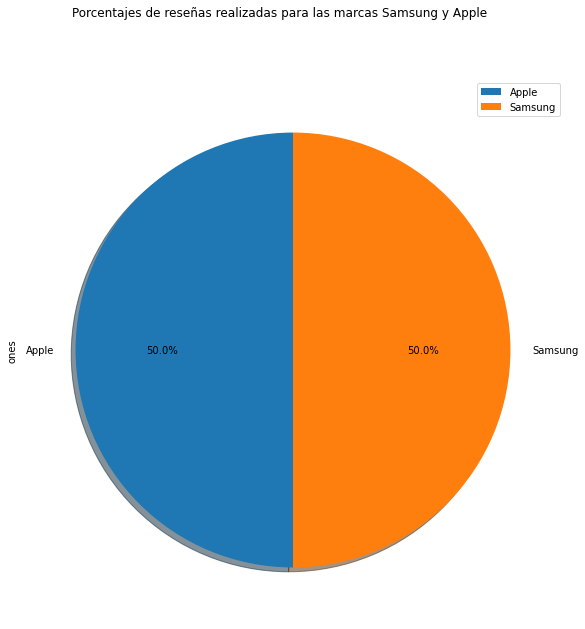

In [67]:
brand1_ss = brand1.sample(brand2.shape[0])
df = pd.concat([brand2, brand1_ss])

print("Samsung subset: ", brand1_ss.shape,"\n")
print("Datos: ", df.shape,"\n")

# Porcentaje por marcas de intéres
df.groupby(['brand']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=90,figsize=(15,10), autopct='%1.1f%%',title='Porcentajes de reseñas realizadas para las marcas Samsung y Apple')

Validar y eliminar valores nulos:

In [68]:
df = df[pd.notnull(df['brand'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9750 entries, 13192 to 44315
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   9750 non-null   object 
 1   body    9750 non-null   object 
 2   brand   9750 non-null   object 
 3   ones    9750 non-null   float64
dtypes: float64(1), object(3)
memory usage: 380.9+ KB


Eliminar columnas inncesarias. Solo se conserva el cuerpo de la reseña y la marca del teléfono

In [69]:
col = ['brand', 'body']
df = df[col]
df.columns

Index(['brand', 'body'], dtype='object')

Se asigna un id a cada marca:

- Apple:    0
- Samsung:  1

In [70]:
df['brand_id'] = df['brand'].factorize()[0]
from io import StringIO
brand_id_df = df[['brand', 'brand_id']].drop_duplicates().sort_values('brand_id')
brand_to_id = dict(brand_id_df.values)
id_to_brand = dict(brand_id_df[['brand_id', 'brand']].values)

print(df.head())
print("\n", "brand_id_df: ", "\n", brand_id_df)
print("\n", "brand_to_id: ", "\n", brand_to_id)
print("\n", "id_to_brand: ", "\n", id_to_brand)

       brand                                               body  brand_id
13192  Apple  Wrong product... it said iPad Air and it’s an ...         0
13193  Apple                         I’m had a dent in the back         0
13194  Apple  Purchased this certified refurbished iPad Air ...         0
13195  Apple                                      Love it!!!!!!         0
13196  Apple  There is no sims card in this. iPad. I assumed...         0

 brand_id_df:  
          brand  brand_id
13192    Apple         0
11137  Samsung         1

 brand_to_id:  
 {'Apple': 0, 'Samsung': 1}

 id_to_brand:  
 {0: 'Apple', 1: 'Samsung'}


Gráfico de número de reseñas por marca:

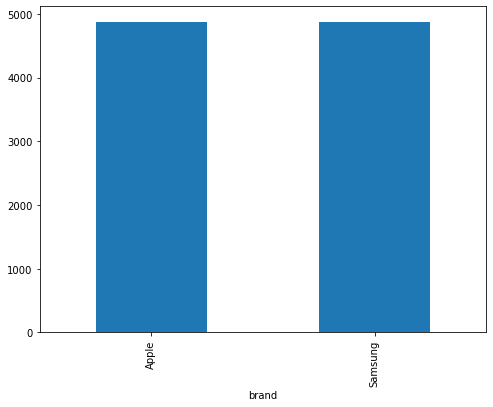

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('brand').body.count().plot.bar(ylim=0)
plt.show()

Se utiliza el "TfidfVectorizer" para convertir la colección de reseñas en una matriz de características de TF-IDF o "Term Frequency – Inverse Document" por sus siglas en inglés. 

Esta función tokeniza



In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.body).toarray()
labels = df.brand_id
features.shape

(9750, 6022)

In [73]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Body, brand_id in sorted(brand_to_id.items()):
  features_chi2 = chi2(features, labels == brand_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Body))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Apple':
  . Most correlated unigrams:
       . samsung
       . iphone
  . Most correlated bigrams:
       . love phone
       . great phone
# 'Samsung':
  . Most correlated unigrams:
       . samsung
       . iphone
  . Most correlated bigrams:
       . love phone
       . great phone


e:\Coding\Python\Anaconda\envs\ProcesamientoDatos\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
e:\Coding\Python\Anaconda\envs\ProcesamientoDatos\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['body'], df['brand'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [76]:
print(clf.predict(count_vect.transform([" "])))

['Apple']


In [77]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Samsung']


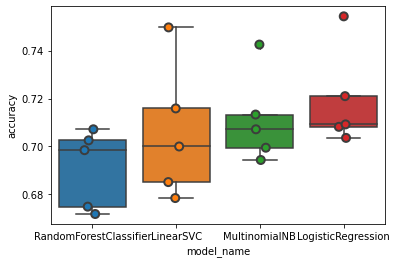

<Figure size 432x864 with 0 Axes>

In [78]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.figure(figsize=(6, 12))
plt.show()

In [79]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.705846
LogisticRegression        0.719282
MultinomialNB             0.711385
RandomForestClassifier    0.690974
Name: accuracy, dtype: float64

In [80]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

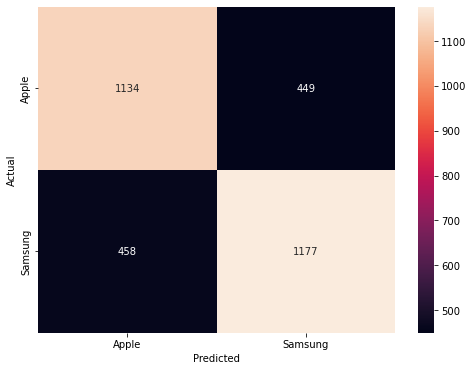

In [81]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=brand_id_df.brand.values, yticklabels=brand_id_df.brand.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [82]:
from IPython.display import display

for predicted in brand_id_df.brand_id:
  for actual in brand_id_df.brand_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_brand[actual], id_to_brand[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['brand', 'body']])
      print('')

'Samsung' predicted as 'Apple' : 458 examples.


,brand,body
5757,Samsung,I doesn t come with memory and earphone
36852,Samsung,First I would like to say that I am very satis...
12093,Samsung,Loving the phone.
38280,Samsung,Bad condition I received it with open carton &...
46742,Samsung,Battery life is not amazing... but it's not ex...
...,...,...
15601,Samsung,"Good deal,"
15609,Samsung,Very Good
52134,Samsung,It has a great look and the cameras amazing!!
49898,Samsung,It works awesomely good!



'Apple' predicted as 'Samsung' : 449 examples.


,brand,body
49539,Apple,It’s great
40274,Apple,Seriously so happy about my phone love love lo...
37771,Apple,"Very good, the seller presented a charging device"
28100,Apple,"it has a very short battery life, but overall ..."
28727,Apple,"Great phone and great seller , recommended!"
...,...,...
26089,Apple,VERY NICE
40317,Apple,"Un desastre, lo devolvi"
27989,Apple,Good phone but does not work for metro pcs
22996,Apple,Battery to bad


In [83]:
A = model.fit(features, labels)
from sklearn.feature_selection import chi2

N = 2
for brand, brand_id in sorted(brand_to_id.items()):
  print(brand)
  print(brand_id)

Apple
0
Samsung
1


In [84]:
texts = ["I requested a refund. This phone sucks.",
         "Great price.",
         "perfect",
         "Great phone. I'm satisifed with my purchase.",
         "My old iphone was not working anymore. Just got another one"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_brand[predicted]))
  print("")

"I requested a refund. This phone sucks."
  - Predicted as: 'Samsung'

"Great price."
  - Predicted as: 'Samsung'

"perfect"
  - Predicted as: 'Apple'

"Great phone. I'm satisifed with my purchase."
  - Predicted as: 'Samsung'

"My old iphone was not working anymore. Just got another one"
  - Predicted as: 'Apple'



In [85]:
print(df['brand'].unique())

['Apple' 'Samsung']


In [86]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1583
           1       0.72      0.72      0.72      1635

    accuracy                           0.72      3218
   macro avg       0.72      0.72      0.72      3218
weighted avg       0.72      0.72      0.72      3218

